<a href="https://colab.research.google.com/github/ArvindMohanta/ArvindMohanta/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
path = "/content/drive/MyDrive/content"

In [ ]:

def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path,include_zip):
    if include_zip==True:
        ZipFile(path+"/DentalPanoramicXrays.zip").extractall(path)
        path=path+'/Images/'
    dirs=natsorted(os.listdir(path))
    # print(dirs);
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images,sizes


X,X_sizes=pre_images((512,512),path,True)

In [ ]:

def pre_splitted_masks(path="/content/drive/MyDrive/content"):
    # ZipFile(path+"/splitted_masks.zip").extractall(path+'/Masks/')
    ZipFile(path+"/splitted_masks.zip").extractall(path+'/Masks')
    path=path+'/Masks/'
    dirs=natsorted(os.listdir(path))
    print(len(dirs))
    masks=img=Image.open(path+dirs[0])
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),512,512,1))
    print(len(dirs))
    return masks

Y=pre_splitted_masks(path='/content/drive/MyDrive/content') #Custom Splitted MASKS size 512x512


X=np.float32(X/255)
Y=np.float32(Y/255)



x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

116
116


In [ ]:

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ujjy5gtd
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-ujjy5gtd
  Resolved https://github.com/albu/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=d5bef78e30b0a04b6268ca07c00bb45beabcc5f3778dbda0f977b6448c7c64b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc8_ilz8/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62


!pip install opencv-python-headless==4.5.2.52

In [ ]:

import cv2

import albumentations as A
#Augmention . Change what you want ! Care about Your GPU and CPU RAM

#If you get error : cannot import name '_registerMatType' from 'cv2.cv2' :
#!pip uninstall opencv-python-headless==4.5.5.62
#!pip install opencv-python-headless==4.5.2.52

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [ ]:
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

23


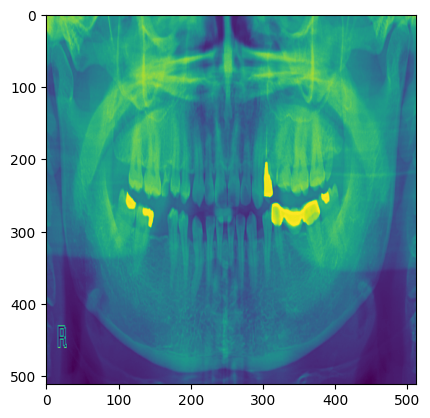

In [ ]:

import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)


plt.imshow(x_train[random_number,:,:,0])

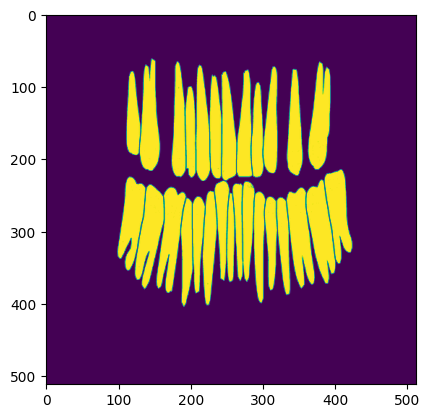

In [ ]:
plt.imshow(y_train[random_number,:,:,0])

In [ ]:

import tensorflow
from tensorflow import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout



# import torch
# import monai
# from monai import config
# from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
# from monai.inferers import sliding_window_inference
# from monai.metrics import DiceMetric
# from monai.networks.nets import UNet

# from monai.networks.layers import Norm, Act
#from keras.models import Sequential, load_model

#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from keras.models import Model


In [ ]:

def UNET1(input_shape=(512,512,1),last_activation='sigmoid'):
    inputs=Input(shape=input_shape)
    conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    d1=Dropout(0.1)(conv1)
    conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
    b=BatchNormalization()(conv2)

    pool1 = MaxPooling2D(pool_size=(2, 2))(b)
    conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    d2=Dropout(0.2)(conv3)
    conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
    b1=BatchNormalization()(conv4)

    pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
    conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    d3=Dropout(0.3)(conv5)
    conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
    b2=BatchNormalization()(conv6)

    pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
    conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    d4=Dropout(0.4)(conv7)
    conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
    b3=BatchNormalization()(conv8)

    pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
    conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    d5=Dropout(0.5)(conv9)
    conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
    b4=BatchNormalization()(conv10)


    conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
    x= concatenate([conv11,conv8])
    conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    d6=Dropout(0.4)(conv12)
    conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
    b5=BatchNormalization()(conv13)


    conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
    x1=concatenate([conv14,conv6])
    conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
    d7=Dropout(0.3)(conv15)
    conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
    b6=BatchNormalization()(conv16)

    conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
    x2=concatenate([conv17,conv4])
    conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
    d8=Dropout(0.2)(conv18)
    conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
    b7=BatchNormalization()(conv19)

    conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
    x3=concatenate([conv20,conv2])
    conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
    d9=Dropout(0.1)(conv21)
    conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)

    outputs = Conv2D(1,(1,1), activation = last_activation, padding = 'same', kernel_initializer = 'he_normal')(conv22)
    model2 = Model( inputs = inputs, outputs = outputs)

    return model2
model=UNET1(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:

model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch
#model.fit(x_train,y_train,batch_size=8,epochs=75,verbose=1)
model.fit(x_train,y_train,batch_size=8,epochs=80,verbose=1)


Epoch 1/80
66/66 [==============================] - 128s 1s/step - loss: 0.3937 - accuracy: 0.7756
Epoch 2/80
66/66 [==============================] - 78s 1s/step - loss: 0.2608 - accuracy: 0.8426
Epoch 3/80
66/66 [==============================] - 78s 1s/step - loss: 0.2077 - accuracy: 0.8627
Epoch 4/80
66/66 [==============================] - 78s 1s/step - loss: 0.1838 - accuracy: 0.8711
Epoch 5/80
66/66 [==============================] - 78s 1s/step - loss: 0.1739 - accuracy: 0.8752
Epoch 6/80
66/66 [==============================] - 78s 1s/step - loss: 0.1648 - accuracy: 0.8791
Epoch 7/80
66/66 [==============================] - 78s 1s/step - loss: 0.1615 - accuracy: 0.8805
Epoch 8/80
66/66 [==============================] - 78s 1s/step - loss: 0.1551 - accuracy: 0.8837
Epoch 9/80
66/66 [==============================] - 78s 1s/step - loss: 0.1495 - accuracy: 0.8851
Epoch 10/80
66/66 [==============================] - 78s 1s/step - loss: 0.1512 - accuracy: 0.8854
Epoch 11/80
66/66 

In [ ]:
predict_img=model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0]


1/1 [==============================] - 1s 506ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')


0.9573728388006036

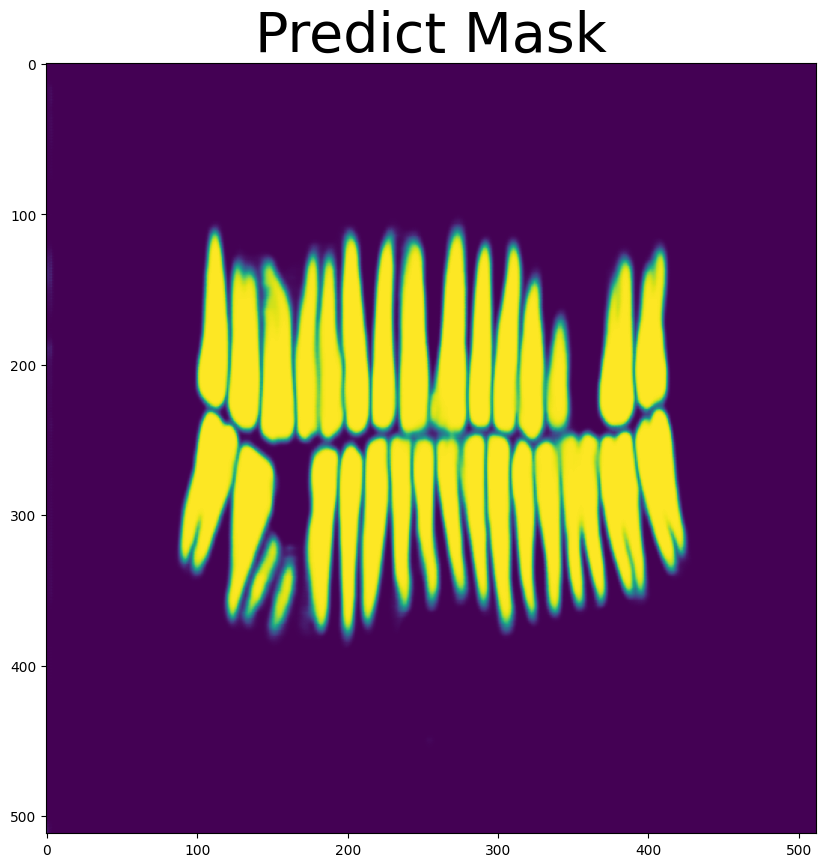

In [ ]:

plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("/content/predict.png",predict)

In [ ]:

model.save(path)

In [ ]:
model.save("my_model")

In [ ]:
#model.save("/content/drive/MyDrive/content/model1")
model.save("/content/drive/MyDrive/content/model2")

In [ ]:

import os

import tensorflow as tf
from tensorflow import keras

new_model = tf.keras.models.load_model('/content/drive/MyDrive/content/model2')

1/1 [==============================] - 43s 43s/step


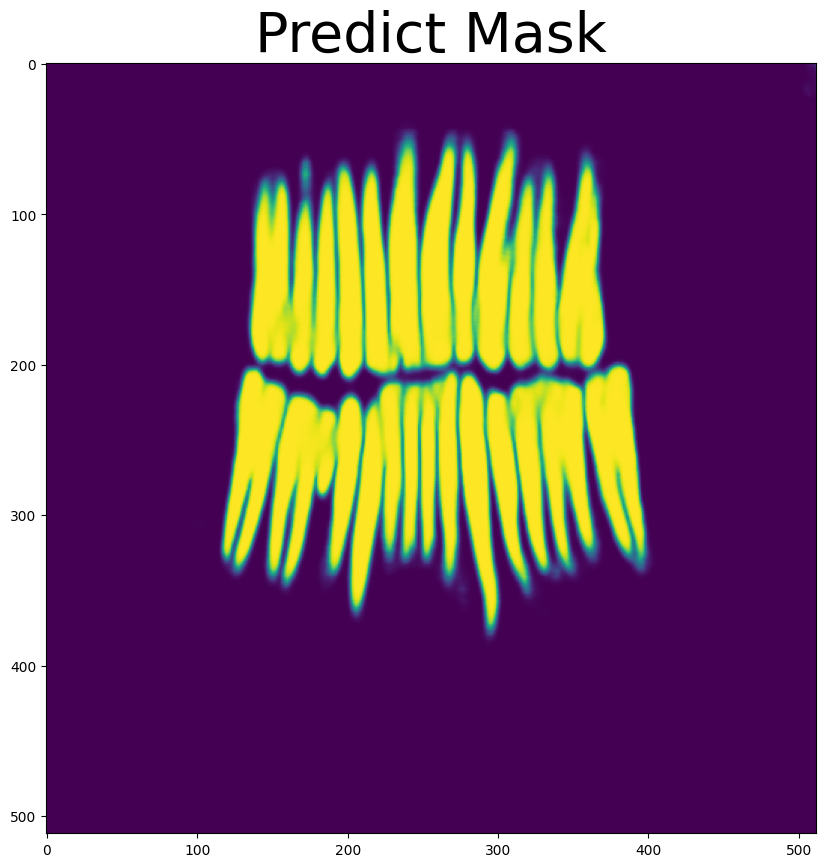

In [ ]:
predict_img=new_model.predict(x_test)
##model.save(path)
predict=predict_img[4,:,:,0]

plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
plt.imsave("/content/predict.png",predict)

In [ ]:
predict_img=new_model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0]

1/1 [==============================] - 43s 43s/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9573728388006036

In [ ]:
import cv2
import numpy as np
from imutils import perspective
from scipy.spatial import distance as dist
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
# Load in image, convert to gray scale, and Otsu's threshold

#Function accept cv2 type
#Only useable splitted masks

def CCA_Analysis(orig_image,predict_image,erode_iteration,open_iteration):
    kernel1 =( np.ones((5,5), dtype=np.float32))
    kernel_sharpening = np.array([[-1,-1,-1],
                                  [-1,9,-1],
                                 [-1,-1,-1]])
    image = predict_image
    image2 =orig_image
    image=cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1,iterations=open_iteration )
    image = cv2.filter2D(image, -1, kernel_sharpening)
    image=cv2.erode(image,kernel1,iterations =erode_iteration)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    labels=cv2.connectedComponents(thresh,connectivity=8)[1]
    a=np.unique(labels)
    count2=0
    for label in a:
        if label == 0:
            continue

        # Create a mask
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255
        # Find contours and determine contour area
        cnts,hieararch = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0]
        c_area = cv2.contourArea(cnts)
        # threshhold for tooth count
        if c_area>2000:
            count2+=1

        (x,y),radius = cv2.minEnclosingCircle(cnts)
        rect = cv2.minAreaRect(cnts)
        box = cv2.boxPoints(rect)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)
        color1 = (list(np.random.choice(range(150), size=3)))
        color =[int(color1[0]), int(color1[1]), int(color1[2])]
        cv2.drawContours(image2,[box.astype("int")],0,color,2)
        (tl,tr,br,bl)=box

        (tltrX,tltrY)=midpoint(tl,tr)
        (blbrX,blbrY)=midpoint(bl,br)
    	# compute the midpoint between the top-left and top-right points,
    	# followed by the midpoint between the top-righ and bottom-right
        (tlblX,tlblY)=midpoint(tl,bl)
        (trbrX,trbrY)=midpoint(tr,br)
    	# draw the midpoints on the image
        cv2.circle(image2, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        cv2.line(image2, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),color, 2)
        cv2.line(image2, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),color, 2)
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))



        pixelsPerMetric=1
        dimA = dA * pixelsPerMetric
        dimB = dB *pixelsPerMetric
        cv2.putText(image2, "{:.1f}pixel".format(dimA),(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
        cv2.putText(image2, "{:.1f}pixel".format(dimB),(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
        cv2.putText(image2, "{:.1f}".format(label),(int(tltrX - 35), int(tltrY - 5)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
    teeth_count=count2
    return image2,teeth_count


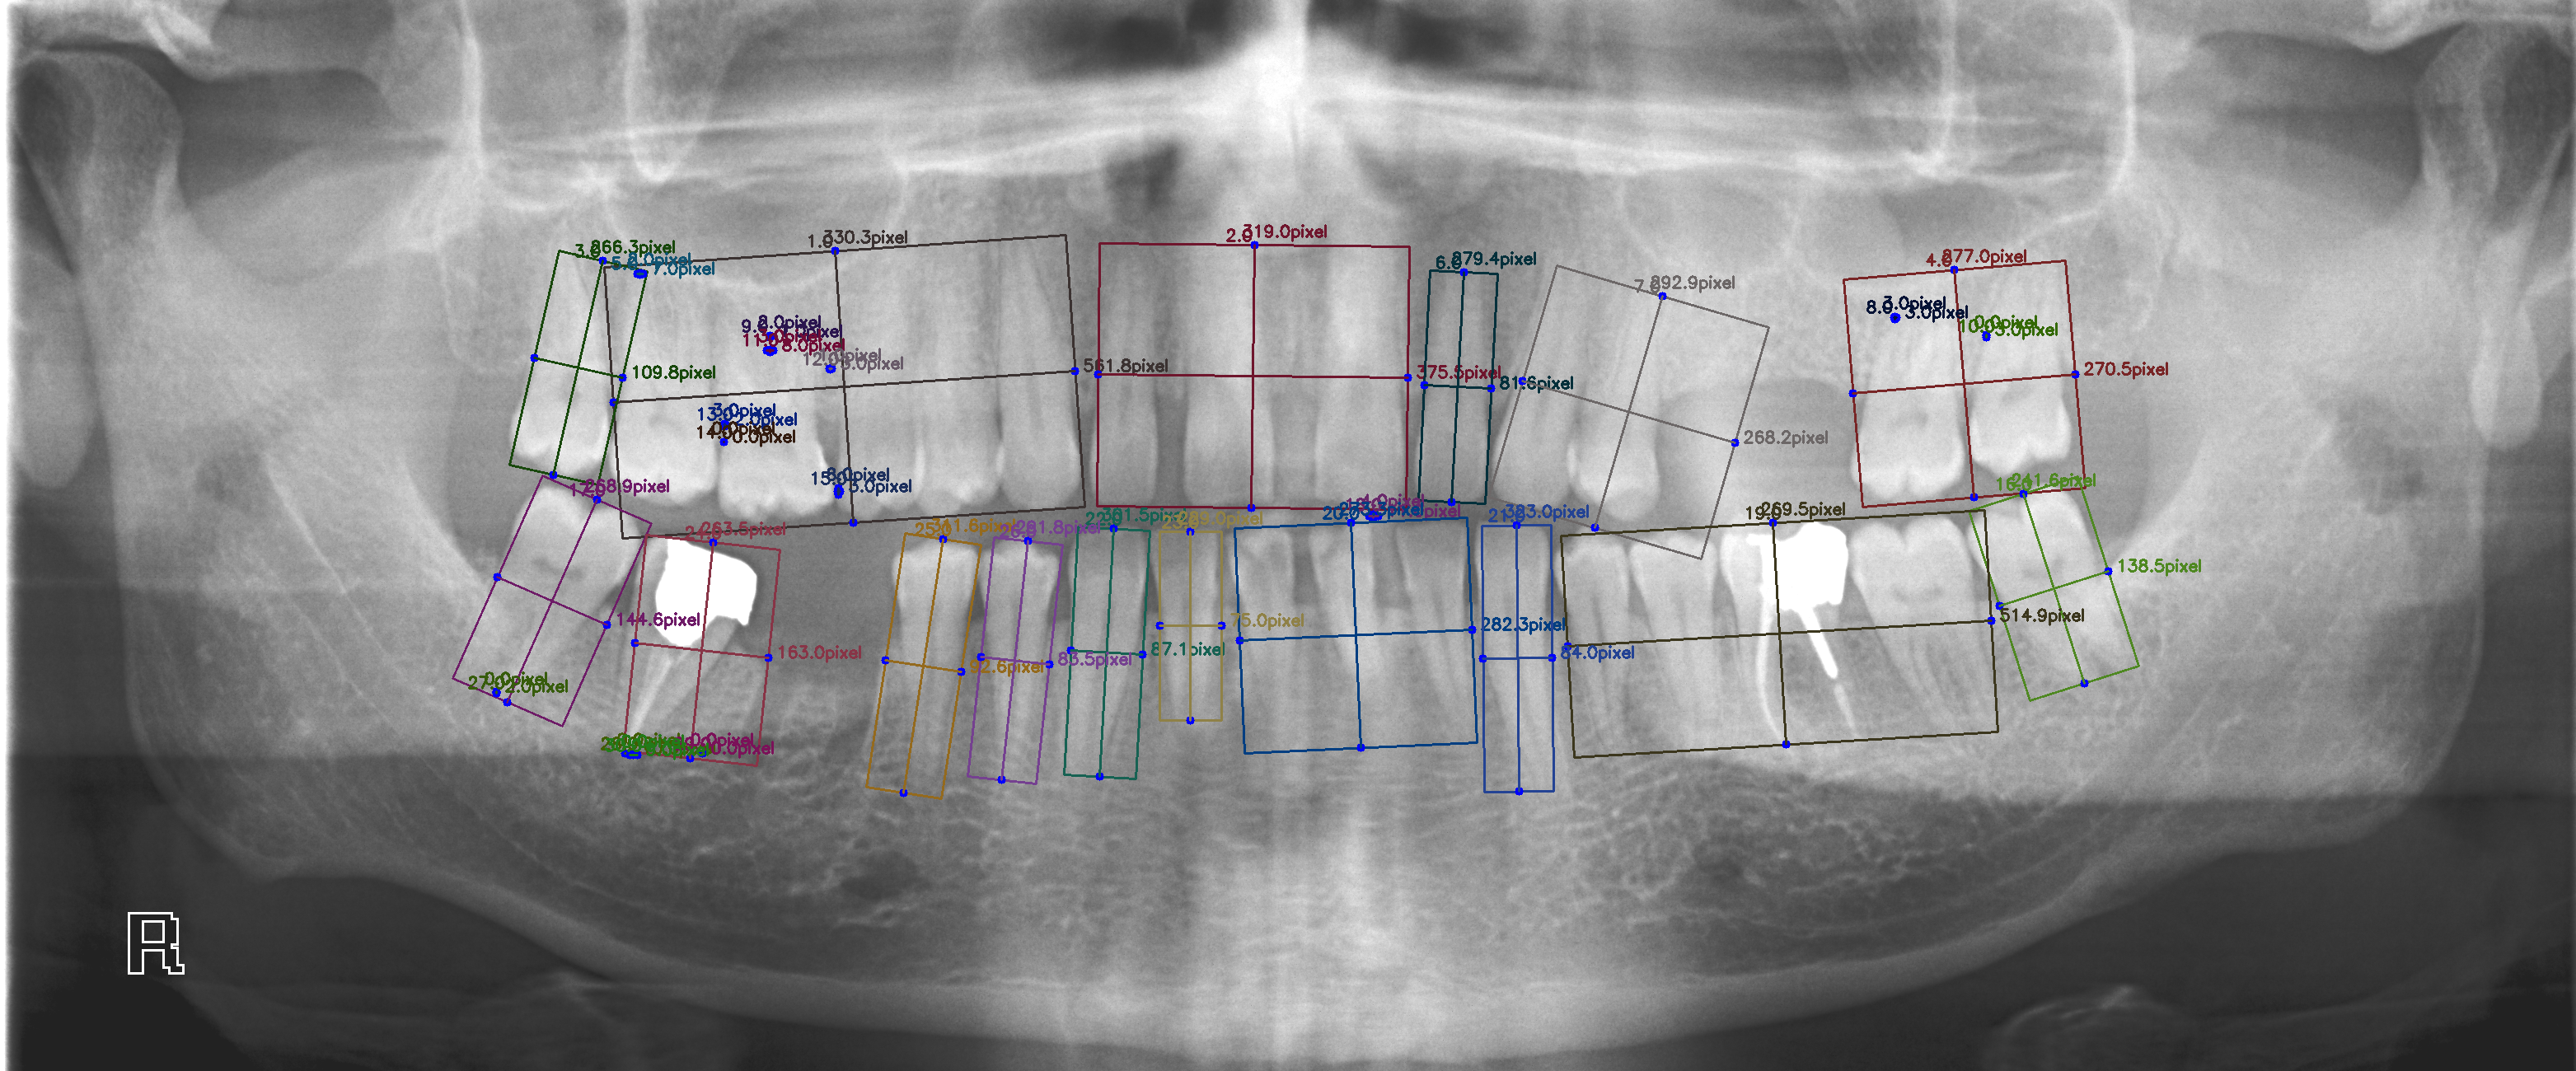

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


img=cv2.imread("/content/drive/MyDrive/content/Images/107.png")#original img 107.png

#predict=cv2.imread("/content/drive/MyDrive/content/Masks/107.png")
#predict=cv2.cvtColor(predict, cv2.COLOR_BGR2GRAY)

predicted=cv2.imread("/content/predict.png")
#load image (mask was saved by matplotlib.pyplot)

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)


cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)

cv2_imshow(cca_result)

In [ ]:
print(teeth_count,"Teeth Count")